<a href="https://colab.research.google.com/github/lorebianchi98/BrainTumorClassification/blob/main/7_Ensemble.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ensemble
In this notebook we will create ensemble models from the best model developed. In particular we will focus in obtaining a model with the best accuracy on the test set and a model with the best precision on no tumor images.

# Import and Costants

In [ ]:
!pip install tensorflow_addons
!pip install --quiet vit-keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 7.8 MB/s 


In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras import models
import numpy as np
import pandas as pd
from tensorflow import keras
import os
import shutil
import matplotlib.pyplot as plt
from tqdm import tqdm
from google.colab import drive
from keras.models import Model
import pdb
import matplotlib.cm as cm
import tensorflow_addons as tfa
from vit_keras import vit
import random as rn

# Connection to Google Drive

In [ ]:
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


We also perform the download and the unzipping of the dataset from the drive folder.

In [ ]:
!unzip -q '/content/gdrive/MyDrive/BrainTumorClassifier/brain-tumor-mri-splits.zip' -d '/'

# Utility functions

In [ ]:
% run /content/gdrive/MyDrive/BrainTumorClassifier/utilities.ipynb

In the function to evaluate a model we return the accuracy on the set and the precision on the notumor class, since we are interested in the capability of a model to not assign the notumor label to a brain with a tumor.

In [ ]:
def evaluate_model(true_labels, predicted_labels):
  print("Accuracy on the set: " + str(metrics.accuracy_score(true_labels, predicted_labels)))
  print(metrics.classification_report(true_labels, predicted_labels, target_names=CLASSES, digits=4))
  # plot confusion matrix
  fig, ax = plt.subplots(figsize=(10, 10))
  ConfusionMatrixDisplay.from_predictions(true_labels, predicted_labels, xticks_rotation='vertical', ax=ax, display_labels=CLASSES)
  
def get_accuracy_and_notumor_precision(true_labels, predicted_labels):
  return metrics.accuracy_score(true_labels, predicted_labels), metrics.precision_score(true_labels, predicted_labels, average='macro',labels=[2])

# Dataset loading
Now we need to create the Dataset objects from the sets directory. 

In [ ]:
train_ds, val_ds, test_ds = load_data_splits(IMAGE_SIZE, BATCH_SIZE, shuffle_on_val=False)

Found 4213 files belonging to 4 classes.
Found 1404 files belonging to 4 classes.
Found 1406 files belonging to 4 classes.


# Model Loading
We load the best model for each type of network trained (the CNN from scratch, VGG16, ResNet and Densenet). As parameter to value a model we considered the accuracy on the test set.

In [ ]:
from_scratch_model = models.load_model(MODELS_PATH + '/Dense512Neurons_TwoDropouts0-3_AdditionalLayer/Dense512Neurons_TwoDropouts0-3_AdditionalLayer.h5')
vgg_model = models.load_model(MODELS_PATH + '/VGG16_LastBlockFineTuned/VGG16_LastBlockFineTuned.h5')
vgg2_model = models.load_model(MODELS_PATH + '/VGG16_LastBlockFineTunedEntirely/VGG16_LastBlockFineTunedEntirely.h5')
resnet_model = models.load_model(MODELS_PATH + '/ResNet50_Finetuned/ResNet50_Finetuned.h5')
densenet_model = models.load_model(MODELS_PATH + '/DenseNet121_Finetuned/DenseNet121_Finetuned.h5')
vit_model = models.load_model(MODELS_PATH + "/VisionTransformerb32_Dense256_Finetuning/"+"VisionTransformerb32_Dense256_Finetuning.h5")

#Retrieves prediction
We calculate the results fo each model on the test set and we concatenate the results on a single list object. The same procedure is done also for the validation set, since this results will be useful when  we are gonna find the best weights for the ensemble model.

## Test set
We perform the prediction on the test set and retrieves the true label of the dataset.

In [ ]:
from_scratch_test_scores = from_scratch_model.predict(test_ds)
vgg_test_scores = vgg_model.predict(test_ds)
vgg2_test_scores = vgg2_model.predict(test_ds)
resnet_test_scores = resnet_model.predict(test_ds)
densenet_test_scores = densenet_model.predict(test_ds)
vit_test_scores = vit_model.predict(test_ds)

In [ ]:
model_test_scores = [from_scratch_test_scores, vgg_test_scores, vgg2_test_scores, resnet_test_scores, vit_test_scores, densenet_test_scores]

In [ ]:
test_labels = tf.concat([label for image, label in test_ds], axis = 0)

## Validation set
We perform the prediction on the val set and retrieves the true label of the dataset.

In [ ]:
from_scratch_val_scores = from_scratch_model.predict(val_ds)
vgg_val_scores = vgg_model.predict(val_ds)
vgg2_val_scores = vgg2_model.predict(val_ds)
resnet_val_scores = resnet_model.predict(val_ds)
densenet_val_scores = densenet_model.predict(val_ds)
vit_val_scores = vit_model.predict(val_ds)

In [ ]:
model_val_scores = [from_scratch_val_scores, vgg_val_scores, vgg2_val_scores, resnet_val_scores, vit_val_scores, densenet_val_scores]

In [ ]:
val_labels = tf.concat([label for image, label in val_ds], axis = 0)

# Average Model
The easiest way to aggregate the predictions of a set of classifiers is to average their predictions and to extract the ensemble classified label from this prediction. 

Accuracy on the set: 0.9743954480796586
              precision    recall  f1-score   support

      glioma     0.9693    0.9723    0.9708       325
  meningioma     0.9461    0.9605    0.9532       329
     notumor     0.9876    0.9925    0.9900       400
   pituitary     0.9913    0.9688    0.9799       352

    accuracy                         0.9744      1406
   macro avg     0.9736    0.9735    0.9735      1406
weighted avg     0.9746    0.9744    0.9744      1406



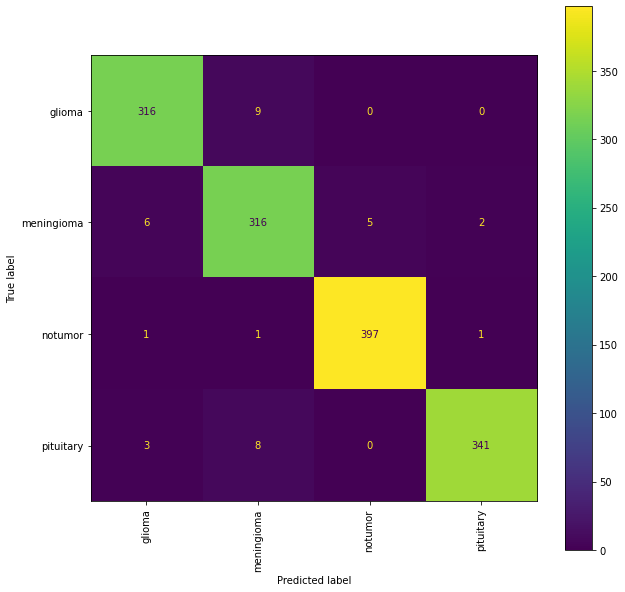

In [ ]:
model_test_scores = np.array(model_test_scores)
ensemble_scores = np.mean(model_test_scores, axis=0)
ensemble_prediction = np.argmax(ensemble_scores, axis=-1) # argmax across classes

evaluate_model(test_labels, ensemble_prediction)

# Weighted Average Model
All classifiers are more or less equally good but, in order to make the most of the ensemble technique, it is smarter to take a weighted average of the predictions so that the best classifiers have higher weights than the worst classifiers.

We are gonna use two different techniques in order to find the best weights of the model. In all the two experiments we will build two models: one which will maximize the accuracy on the validation set and one that will maximize the precision on no tumor image.

## Brute force
One way to found a good set of weights is to try all the weights within a certain step (respecting the constraint that the sum of all the weights needs to be 1) and try all the combinations keeping only the models with the best results on the validation set. Since we have 6 model, choosing a not small step size (0.05), this approach is feasible in a moderate time, but since the algorithmic complexity of this solution is O(step^n), where n is the number of models, this approach becomes unfeasible if the number of model is higher or we want an higher precision decreasing the step size.


The following function will allow us to calculate the weighted average of the predictions of the classifiers. 

In [ ]:
def calculate_ensemble_prediction(model_scores, weights):
  model_scores = np.array(model_scores)
  ensemble_scores = np.average(model_scores, axis=0, weights=weights)
  ensemble_prediction = np.argmax(ensemble_scores, axis=-1) # argmax across classes
  return ensemble_prediction

In [ ]:
def compare_model(modelA, modelB, param1, param2):
  """
  return the best model between modelA and modelB considering first param1 and the param2
  """
  if modelA[param1] > modelB[param1]:
    return modelA
  if modelA[param1] < modelB[param1]:
    return modelB
  #in case of tie we return the best model wrt param2
  return modelA if modelA[param2] > modelB[param2] else modelB

In [ ]:
step = 0.05

#record of the best model wrt accuracy on test set
best_accuracy_model = {'weights':[], 'accuracy':0, 'precision_on_notumor':0 }

#records of the best model wrt precision on test set
best_precision_model = {'weights':[], 'accuracy':0, 'precision_on_notumor':0 }

for a in np.arange(0,1.01,step):
  for b in np.arange(0,1.01,step):
    for c in np.arange(0,1.01,step):
      for d in np.arange(0,1.01,step):
        for e in np.arange(0,1.01,step):
          for f in np.arange(0,1.01,step):
            if (a + b + c + d + e + f== 1):
              predictions = calculate_ensemble_prediction(model_val_scores, [a, b, c, d, e, f])
              acc, prec = get_accuracy_and_notumor_precision(val_labels, predictions)
              new_model = {'weights':[a,b,c,d,e,f], 'accuracy':acc, 'precision_on_notumor':prec}
              best_accuracy_model = compare_model(best_accuracy_model, new_model, 'accuracy', 'precision_on_notumor')
              best_precision_model = compare_model(best_precision_model, new_model, 'precision_on_notumor', 'accuracy')

The weights of the two models found are printed below.

In [ ]:
best_accuracy_model

{'accuracy': 0.9836182336182336,
 'precision_on_notumor': 0.9949874686716792,
 'weights': [0.2, 0.35000000000000003, 0.05, 0.4, 0.0, 0.0]}

In [ ]:
best_precision_model

{'accuracy': 0.9786324786324786,
 'precision_on_notumor': 0.995,
 'weights': [0.4, 0.15000000000000002, 0.0, 0.2, 0.0, 0.25]}

The results of the two models are the following:

Model with best accuracy: 
Weights: [0.2, 0.35000000000000003, 0.05, 0.4, 0.0, 0.0]
Accuracy on the set: 0.9694167852062588
              precision    recall  f1-score   support

      glioma     0.9720    0.9631    0.9675       325
  meningioma     0.9375    0.9574    0.9474       329
     notumor     0.9802    0.9900    0.9851       400
   pituitary     0.9855    0.9631    0.9741       352

    accuracy                         0.9694      1406
   macro avg     0.9688    0.9684    0.9685      1406
weighted avg     0.9696    0.9694    0.9695      1406



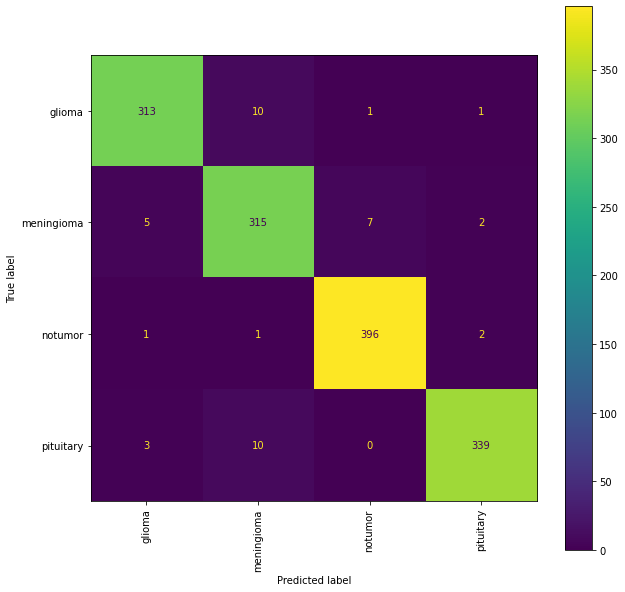

In [ ]:
print("Model with best accuracy: ")
print("Weights: " + str(best_accuracy_model['weights']))
best_acc_predictions = calculate_ensemble_prediction(model_test_scores, best_accuracy_model['weights'])
evaluate_model(test_labels, best_acc_predictions)

Model with best precision on notumor images: 
Weights: [0.4, 0.15000000000000002, 0.0, 0.2, 0.0, 0.25]
Accuracy on the set: 0.9715504978662873
              precision    recall  f1-score   support

      glioma     0.9720    0.9600    0.9659       325
  meningioma     0.9349    0.9605    0.9475       329
     notumor     0.9876    0.9975    0.9925       400
   pituitary     0.9883    0.9631    0.9755       352

    accuracy                         0.9716      1406
   macro avg     0.9707    0.9703    0.9704      1406
weighted avg     0.9718    0.9716    0.9716      1406



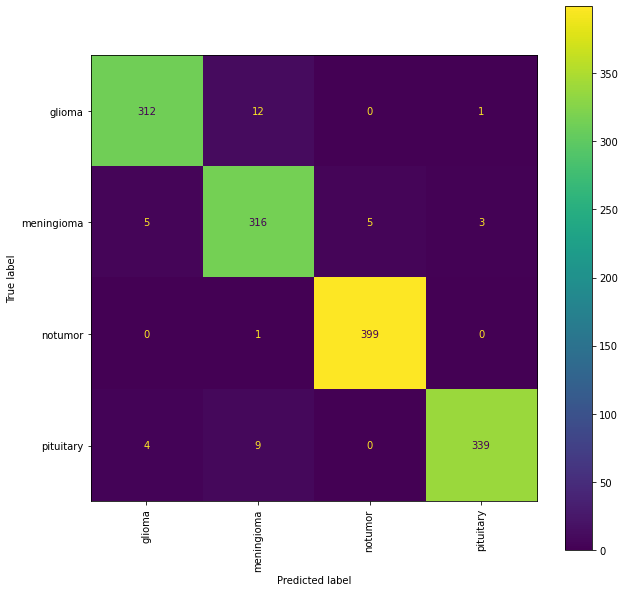

In [ ]:
print("Model with best precision on notumor images: ")
print("Weights: " + str(best_precision_model['weights']))
best_prec_predictions = calculate_ensemble_prediction(model_test_scores, best_precision_model['weights'])
evaluate_model(test_labels, best_prec_predictions)

## Genetic Algorithm
The weights of the model can be found with a Genetic algorithm where chromosomes are composed by six genes (representing the weight of each model). Each transformation (crossover and mutation) will keep the sum of the genes of each chromosome equal to one. 

We will run the algorithm two times with two different fitness functions: one is the accuracy on validation set and one is the precision on no tumor images.




In [ ]:
def get_accuracy(weights): #First fit function
   predictions = calculate_ensemble_prediction(model_val_scores, weights)
   return metrics.accuracy_score(val_labels, predictions)

def get_precision_on_notumor(weights): #Second fit function
   predictions = calculate_ensemble_prediction(model_val_scores, weights)
   return metrics.precision_score(val_labels, predictions, average='macro',labels=[2])

The function for performing the genetic algorithm are written below. The code is inspired by [a post]('https://machinelearningmastery.com/simple-genetic-algorithm-from-scratch-in-python/') found on machinelearningmastery.com, we just needed to add the normalization of each chromosome generated since the sum of the genes must be one.

In [ ]:
# tournament selection
def tournament_selection(population, scores, k=5):
  selection_indexes = [rn.randrange(0, len(population), 1) for i in range(k)]
  selected_index = selection_indexes[0]
  for i in selection_indexes[1:]:
    
    if scores[i] > scores[selected_index]:
      selected_index = i
  return population[selected_index]

# average crossover
def crossover(parent_1, parent_2, r_genes):
  children_1, children_2 = parent_1.copy(), parent_2.copy()
  random_genes_indexes = [rn.randrange(0, len(parent_1), 1) for i in range(r_genes)]
  for i in random_genes_indexes:
    average = (parent_1[i] + parent_2[i])/2
    children_1[i] = average
    children_2[i] = average
  return [[float(i)/sum(children_1) for i in children_1], 
          [float(i)/sum(children_2) for i in children_2]] # we normalize in order to keep the sum of the genes equal to 1

# all-positions mutation
def mutation(chromosome):
  index = rn.randint(0, len(chromosome)-1)
  chromosome[index] = rn.random()
  return [float(i)/sum(chromosome) for i in chromosome] # we normalize in order to keep the sum of the genes equal to 1



def genetic_algorithm(fitness, number_of_models, population_size, number_of_generations, p_crossover, p_mutation):
  # initial population of random chromosomes
  population = []
  for i in range(population_size):
    chromosome = [rn.random() for _ in range(number_of_models)]
    chromosome = [float(i)/sum(chromosome) for i in chromosome]
    population.insert(i, chromosome)
  # keep track of best solution
  best_chromosome, best_fitness = 0, fitness(population[0])
  # enumerate generations
  for generation in range(number_of_generations):
    # evaluate all candidates in the population
    scores = [fitness(chromosome) for chromosome in population]
    # check for new best solution
    new_best = False
    for i in range(population_size):
      if scores[i] > best_fitness:
        new_best = True
        best_chromosome, best_fitness = population[i], scores[i]
    if new_best:
      print("Generation %d, best fitness = %.4f" % (generation+1, best_fitness))
    # select parents
    selected = [tournament_selection(population, scores) for _ in range(population_size)]
    # create the next generation
    children = []
    for i in range(0, population_size, 2):
      # get selected parents in pairs
      p1, p2 = selected[i], selected[i+1]
      # crossover and mutation
      if rn.random() < p_crossover:
        for c in crossover(p1, p2, r_genes=2):
          if rn.random() < p_mutation:
            # mutation
            mutation(c)
          # store for next generation
          children.append(c)
      else:
        children.append(p1)
        children.append(p2)
    # replace population
    population = children
  return [best_chromosome, best_fitness]

We find the model with the best accuracy:

In [ ]:
weights_best_acc = []
best_fitness = 0
for i in range(8):
  print("Iteration: " + str(i))
  weights, fitness = genetic_algorithm(get_accuracy, 6, 100, 50, 0.5, 0.01)
  if fitness > best_fitness:
    best_fitness = fitness
    weights_best_acc = weights
  print()

Iteration: 0
Generation 1, best fitness = 0.9836

Iteration: 1
Generation 1, best fitness = 0.9829

Iteration: 2
Generation 1, best fitness = 0.9829
Generation 4, best fitness = 0.9836

Iteration: 3
Generation 1, best fitness = 0.9815
Generation 3, best fitness = 0.9822
Generation 7, best fitness = 0.9829
Generation 9, best fitness = 0.9836

Iteration: 4
Generation 1, best fitness = 0.9822
Generation 3, best fitness = 0.9829
Generation 5, best fitness = 0.9836

Iteration: 5
Generation 1, best fitness = 0.9815
Generation 3, best fitness = 0.9822
Generation 4, best fitness = 0.9829
Generation 5, best fitness = 0.9836

Iteration: 6
Generation 1, best fitness = 0.9822
Generation 3, best fitness = 0.9829
Generation 6, best fitness = 0.9836

Iteration: 7
Generation 1, best fitness = 0.9822
Generation 2, best fitness = 0.9829
Generation 3, best fitness = 0.9836



In [ ]:
print(weights_best_acc)

[0.1986029095943389, 0.31829453290803167, 0.008992576909267537, 0.3342054907761426, 0.13412602339953872, 0.005778466412680734]


Accuracy on the set: 0.972972972972973
              precision    recall  f1-score   support

      glioma     0.9783    0.9692    0.9737       325
  meningioma     0.9431    0.9574    0.9502       329
     notumor     0.9826    0.9875    0.9850       400
   pituitary     0.9856    0.9744    0.9800       352

    accuracy                         0.9730      1406
   macro avg     0.9724    0.9722    0.9722      1406
weighted avg     0.9731    0.9730    0.9730      1406



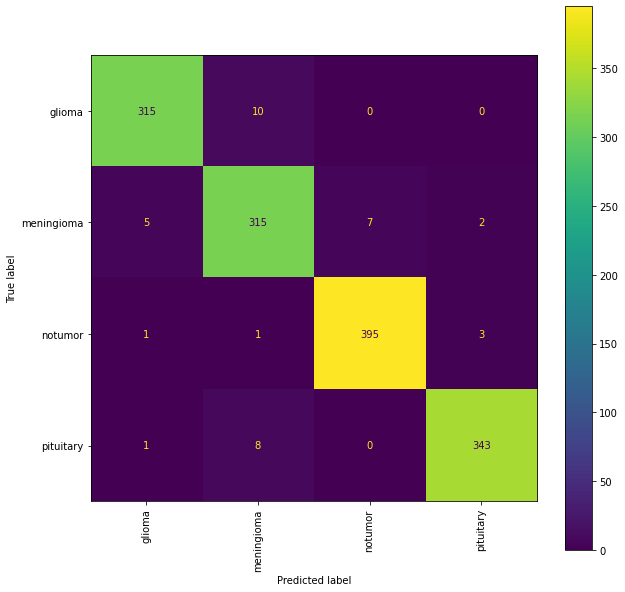

In [ ]:
best_acc_predictions = calculate_ensemble_prediction(model_test_scores, weights_best_acc)
evaluate_model(test_labels, best_acc_predictions)

We find the model with best precision:

In [ ]:
weights_best_prec = []
best_fitness = 0
for i in range(8):
  print("Iteration: " + str(i))
  weights, fitness = genetic_algorithm(get_precision_on_notumor, 6, 100, 50, 0.5, 0.01)
  if fitness > best_fitness:
    best_fitness = fitness
    weights_best_prec = weights
  print()

Iteration: 0
Generation 1, best fitness = 0.9950

Iteration: 1
Generation 1, best fitness = 0.9950

Iteration: 2
Generation 1, best fitness = 0.9950

Iteration: 3
Generation 1, best fitness = 0.9950

Iteration: 4
Generation 1, best fitness = 0.9950

Iteration: 5
Generation 1, best fitness = 0.9950

Iteration: 6
Generation 1, best fitness = 0.9950

Iteration: 7
Generation 1, best fitness = 0.9950



In [ ]:
print(weights_best_prec)

[0.08920340824313877, 0.3380197750624596, 0.057396108034599526, 0.07635628651033366, 0.19225870660774622, 0.24676571554172216]


Accuracy on the set: 0.9751066856330014
              precision    recall  f1-score   support

      glioma     0.9634    0.9723    0.9678       325
  meningioma     0.9489    0.9605    0.9547       329
     notumor     0.9950    0.9900    0.9925       400
   pituitary     0.9885    0.9744    0.9814       352

    accuracy                         0.9751      1406
   macro avg     0.9740    0.9743    0.9741      1406
weighted avg     0.9753    0.9751    0.9752      1406



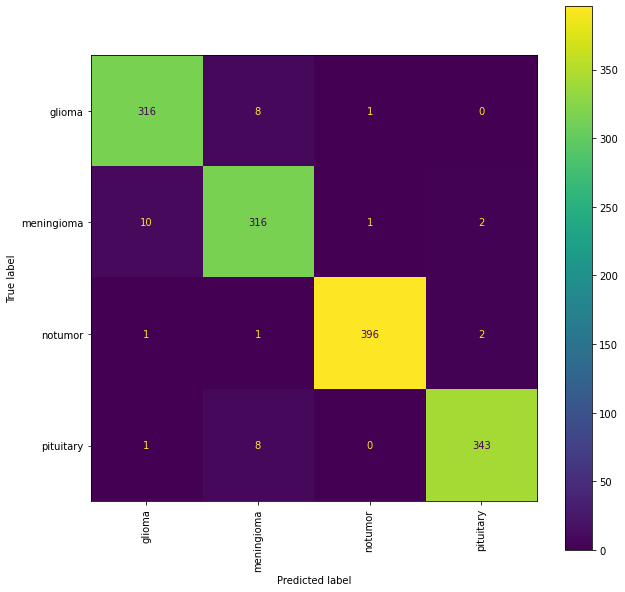

In [ ]:
best_prec_predictions = calculate_ensemble_prediction(model_test_scores, weights_best_prec)
evaluate_model(test_labels, best_prec_predictions)

###Error Analysis
With the genetic algorithm we obtained the best weights for our ensembled model. We are now interested in displaying the misclassified image of the two models.

In [ ]:
misclassified_images_best_acc = np.nonzero(best_acc_predictions - test_labels)[0]
misclassified_images_best_prec = np.nonzero(best_prec_predictions - test_labels)[0]
print("Number of misclassified images by best accuracy model: " + str(len(misclassified_images_best_acc)))
print("Number of misclassified images by best precision on notumor model: " + str(len(misclassified_images_best_prec)))

Number of misclassified images by best accuracy model: 38
Number of misclassified images by best precision on notumor model: 35


In [ ]:
for image, label in test_ds:
  test_images = tf.concat([image for image, label in test_ds], axis = 0)

In [ ]:
def plot_misclassified_images(test_labels, test_images, predicted_labels, misclassified_images, rows = 20, cols = 6):
  plt.figure(figsize=(40, 120))
  i = 0
  for id in misclassified_images:
    img = test_images[id].numpy()
    ax = plt.subplot(rows, cols, i + 1)
    plt.imshow(img.astype("uint8"))
    plt.title("Images " + str(id) + "\nTrue class: " + CLASSES[test_labels[id]] + "\nPredicted class: " + CLASSES[predicted_labels[id]])
    plt.axis("off")
    i += 1


The misclassified images of the best accuracy on validation set model are the following:

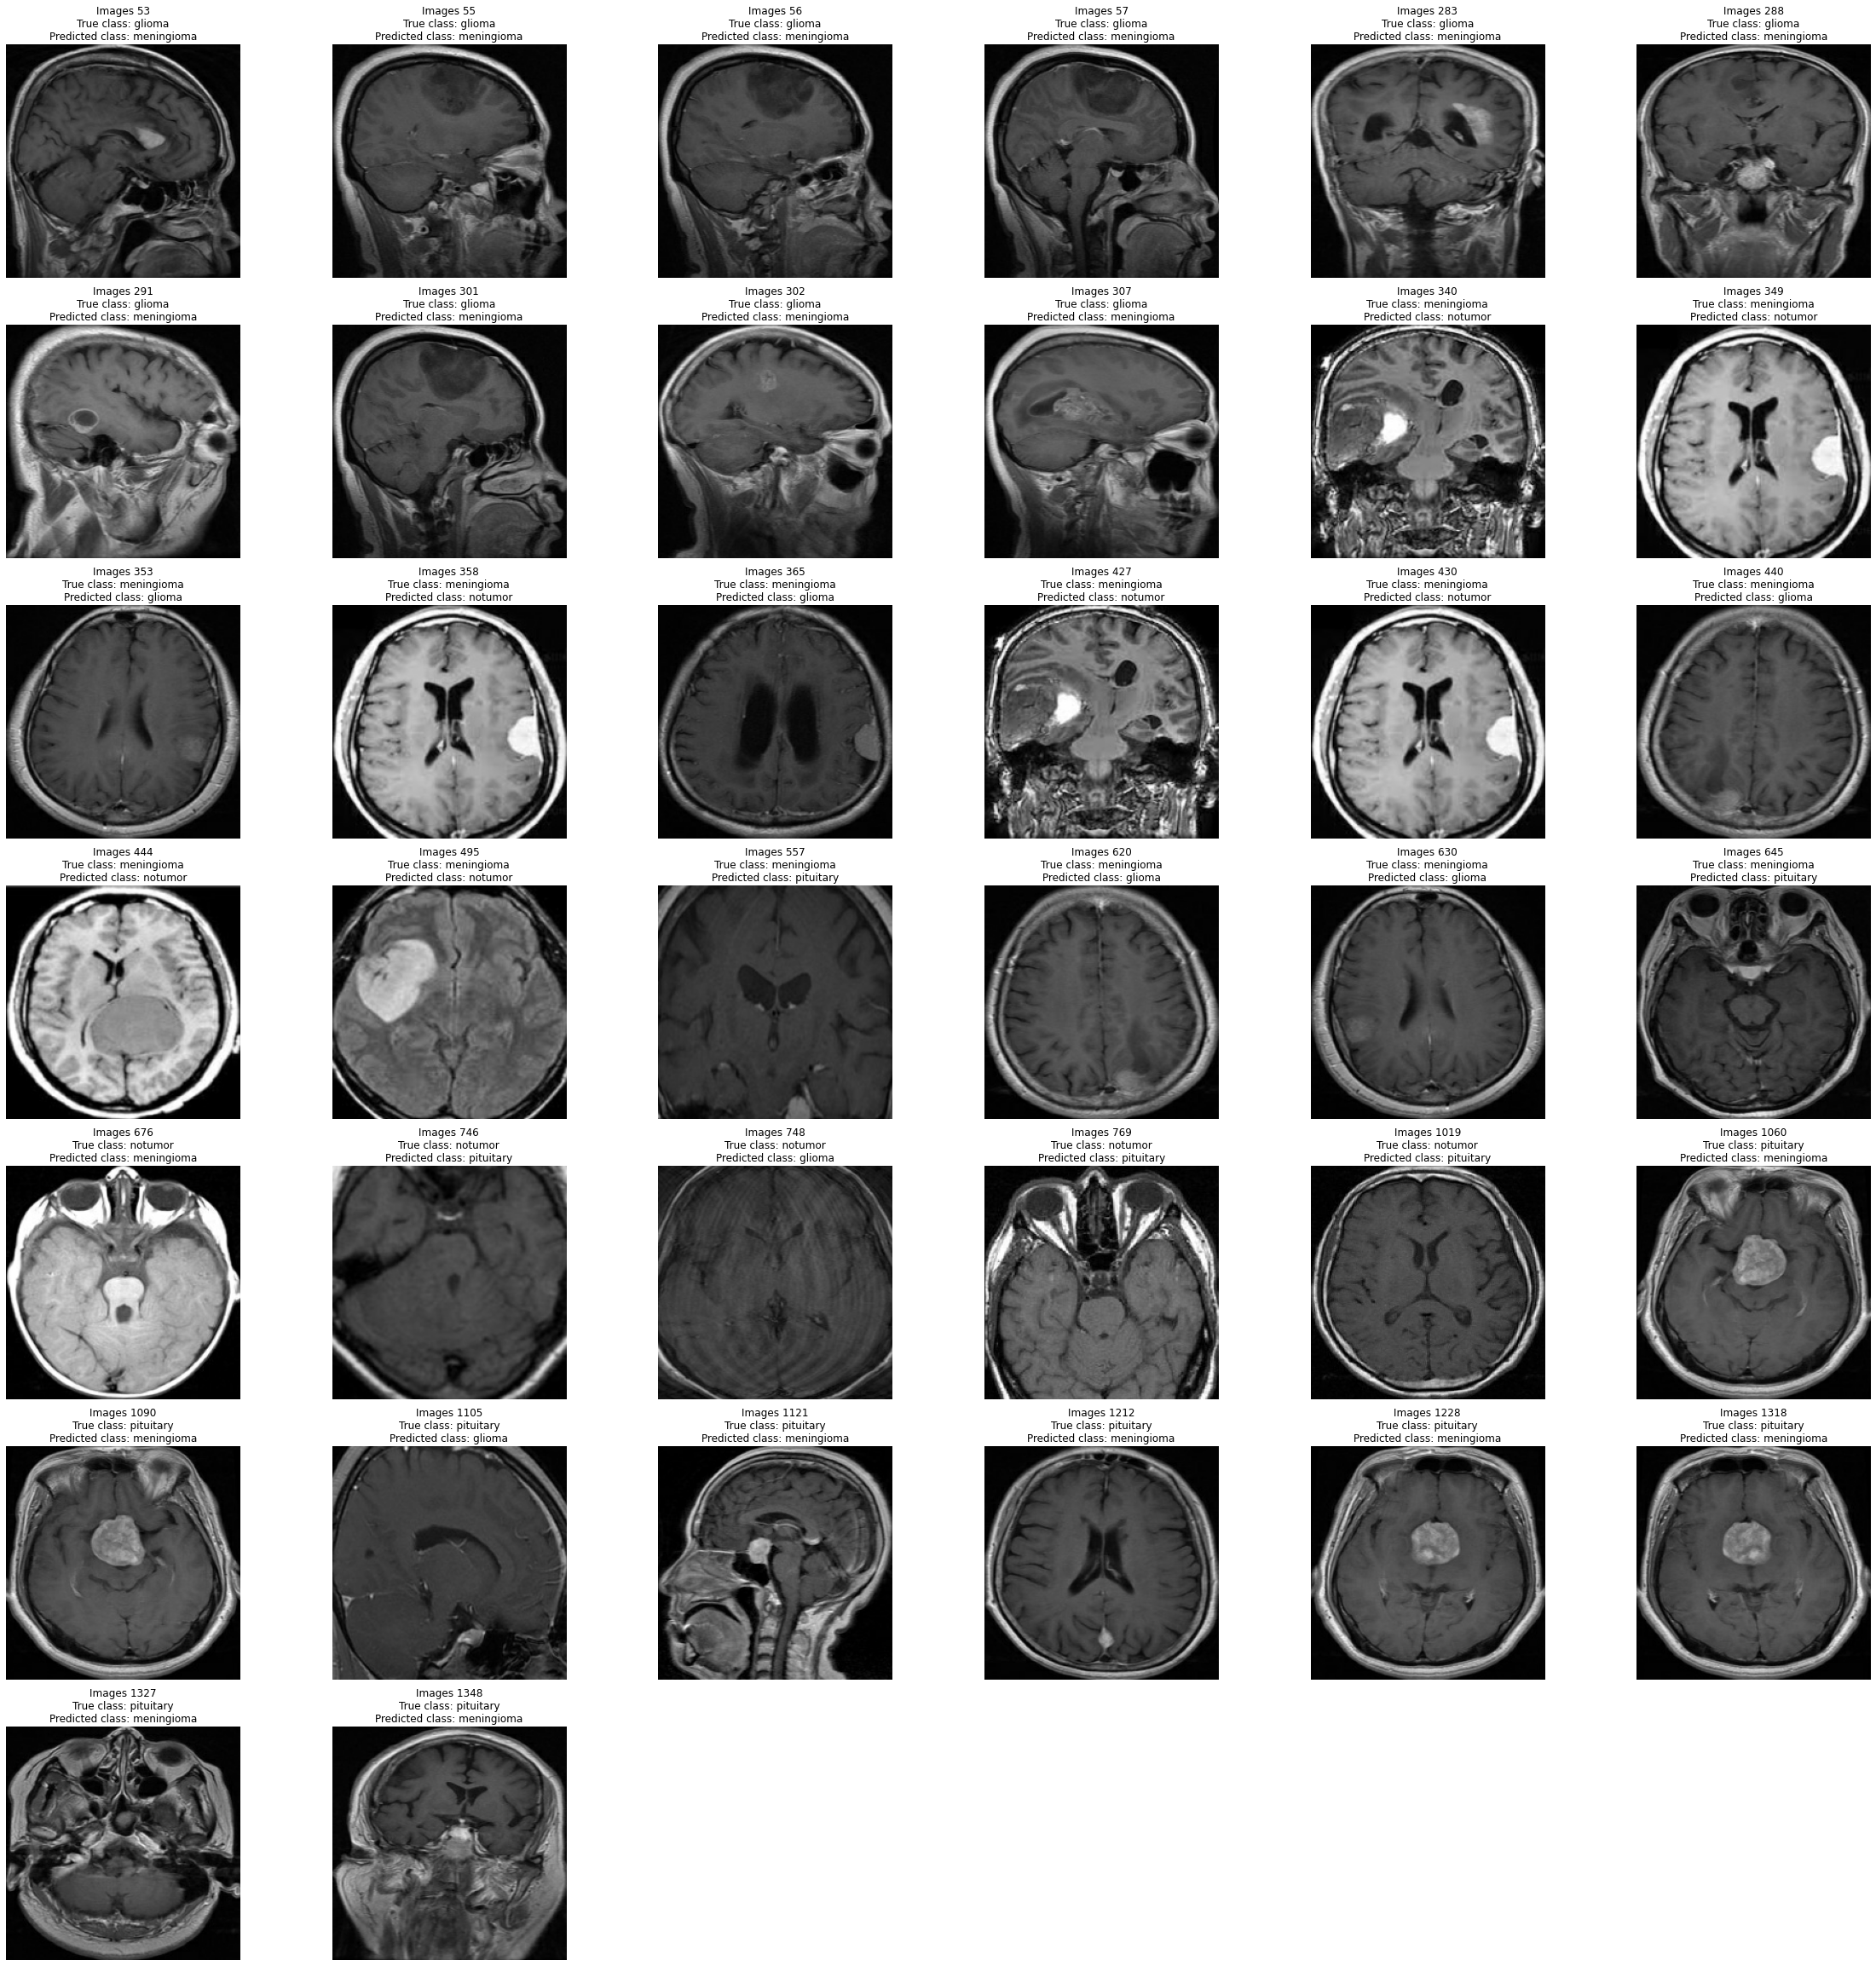

In [ ]:
plot_misclassified_images(test_labels, test_images, best_acc_predictions, misclassified_images_best_acc)

The misclassified images of the best precision on no tumor model are the following:

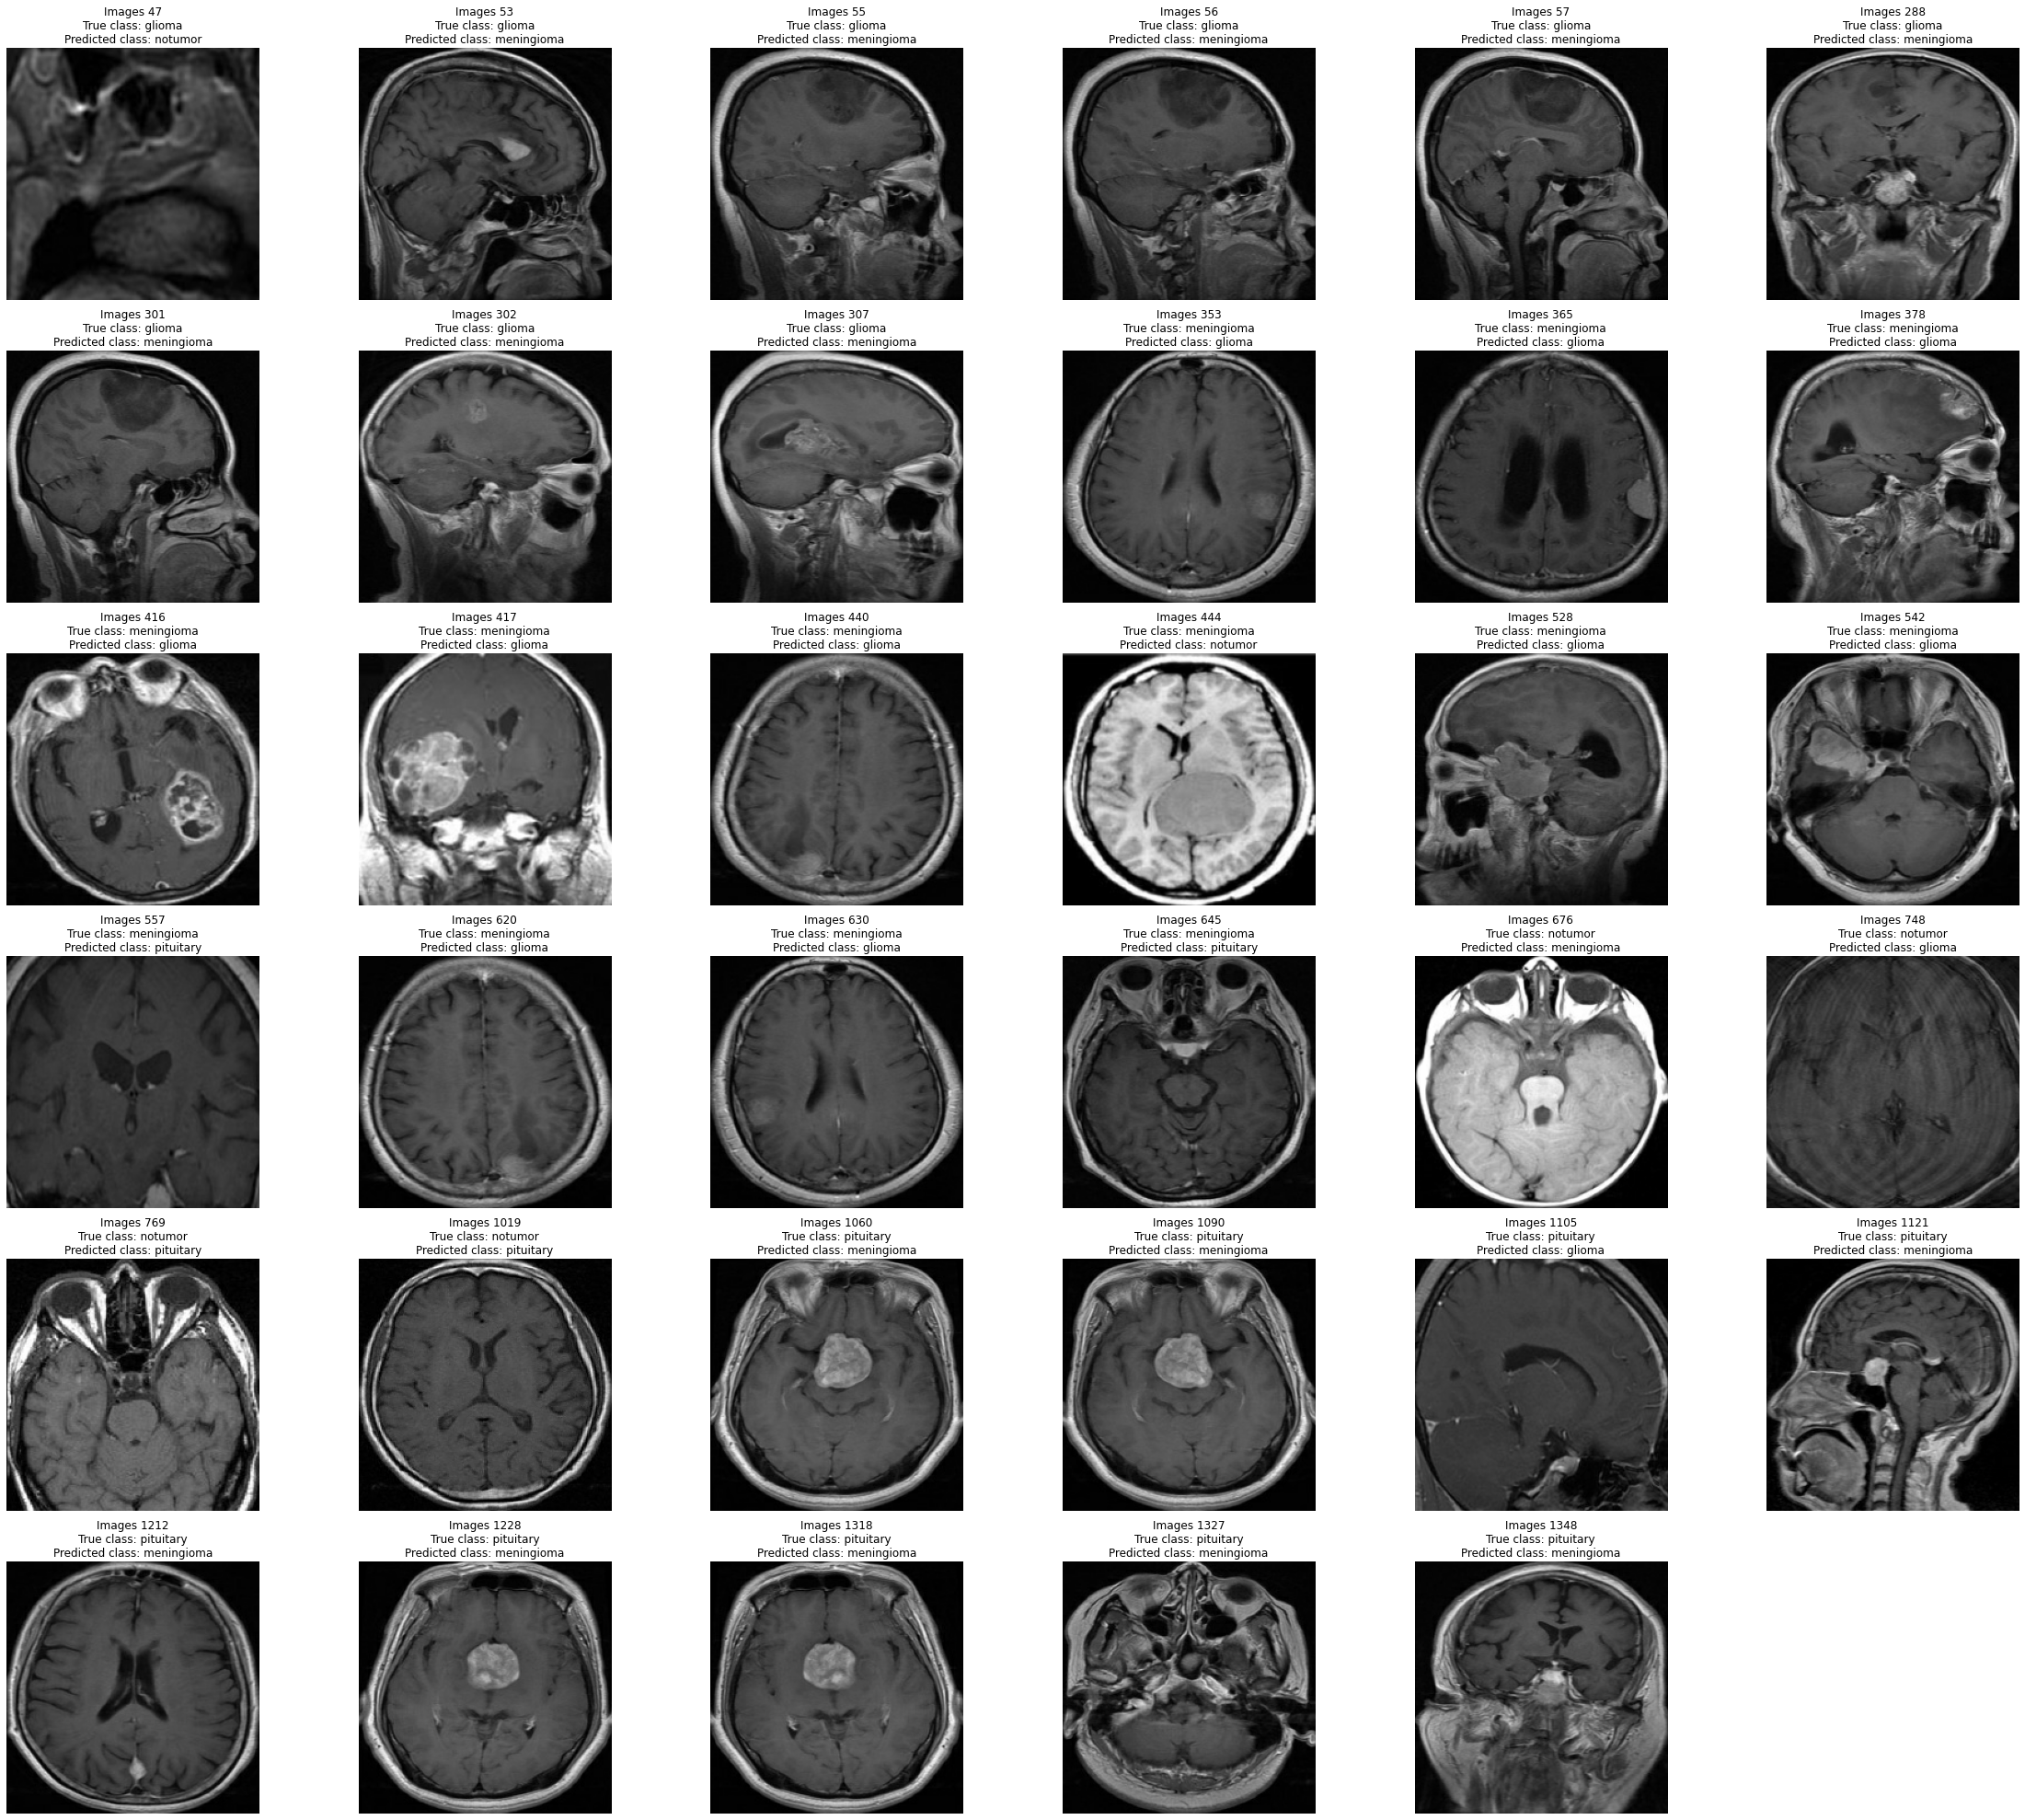

In [ ]:
plot_misclassified_images(test_labels, test_images, best_prec_predictions, misclassified_images_best_prec)